In [1]:
import Pkg
Pkg.activate("../../")

  Activating project at `~/Documents/Research/MonitoringMetrology/notebooks`


In [2]:
using Plots, Mmap, Statistics, TOML, LinearAlgebra, DifferentialEquations, LaTeXStrings, Base.Threads, FFTW
import BackAction.Utilities as util
import BackAction.CoreStructs as cs


In [3]:
function get_lindbladsol(delta, tspan, u0; saveat)
        function rf_ode!(dr, r, p, t)
                dr[1] = -delta * r[2] - 0.5 * GAMMA * r[1]
                dr[2] = -OMEGA * r[3] + delta * r[1] - 0.5 * GAMMA * r[2]
                dr[3] = OMEGA * r[2] - GAMMA * (r[3] + 1)
        end
        prob = ODEProblem(rf_ode!, u0, tspan; saveat=tlist)
        return solve(prob)
end


get_lindbladsol (generic function with 1 method)

In [4]:
cfg = TOML.parsefile("config.toml")
const NCHANNELS0 = cfg["NCHANNELS0"]
const NLEVELS = cfg["NLEVELS"]
const OMEGA = cfg["OMEGA"]
const GAMMA = cfg["GAMMA"]
const tf = 2 * pi / OMEGA * cfg["tffactor"]
const tspan = (0.0, tf)
const tlist = collect(LinRange(tspan[1], tspan[2], cfg["ntimes"]))
const psi0 = [ComplexF64.(cfg["psi0g_re"], cfg["psi0g_im"]),
        ComplexF64.(cfg["psi0e_re"], cfg["psi0e_im"])]
const T = reshape([1.0 + 0.0im], 1, 1)
const e_ops = [util.sigma_x, util.sigma_y, util.sigma_z]
const nops = length(e_ops)
const u0 = [real(dot(psi0, e_ops[1], psi0)),
        real(dot(psi0, e_ops[2], psi0)),
        real(dot(psi0, e_ops[3], psi0))]
const nchannels = size(T)[1]

const nworkers = try
        parse(Int, get(ENV, "SLURM_CPUS_PER_TASK", ""))
catch
        cfg["nworkers"]
end
const cfield = 5.0 + 0.0im
const t = Int(cfg["ntimes"]/2)
const ntimes = cfg["ntimes"] - 1
const ntraj = cfg["ntraj"]
#const dt = tf/cfg["ntimes"];
const dt = tlist[2];2
const e_ops_extended = [I(2), util.sigma_x, util.sigma_y, util.sigma_z]

# Build metadata dictionary (convert non-TOML compatible to strings)
metadata = Dict(
    "NCHANNELS0"      => NCHANNELS0,
    "NLEVELS"         => NLEVELS,
    "OMEGA"           => OMEGA,
    "GAMMA"           => GAMMA,
    "tf"              => tf,
    "tspan"           => string(tspan),
    "ntimes"          => cfg["ntimes"],
    "ntraj"           => ntraj,
    "dt"              => dt,
    "nworkers"        => nworkers,
    "nchannels"       => nchannels,
    "nops"            => nops,
    "psi0"            => string(psi0),
    "u0"              => string(u0),
    "cfield"          => string(cfield),
    "t"               => t,
    "tlist_first"     => first(tlist),
    "tlist_last"      => last(tlist),
)
# Write to TOML file
open("Metadata/metadata_$(real(cfield))_+i$(imag(cfield)).toml", "w") do io
    TOML.print(io, metadata)
end

# Print metadata as TOML

In [5]:
dt*2

0.06630497057827704

In [6]:
tf

6.5973445725385655

In [7]:
tlist[end]

6.5973445725385655

In [8]:
tlist

200-element Vector{Float64}:
 0.0
 0.03315248528913852
 0.06630497057827704
 0.09945745586741556
 0.13260994115655408
 0.1657624264456926
 0.1989149117348311
 0.23206739702396964
 0.26521988231310817
 0.29837236760224667
 0.3315248528913852
 0.3646773381805237
 0.3978298234696622
 ⋮
 6.232667234358042
 6.2658197196471805
 6.298972204936319
 6.3321246902254575
 6.365277175514596
 6.3984296608037345
 6.431582146092873
 6.4647346313820115
 6.4978871166711505
 6.5310396019602885
 6.564192087249427
 6.5973445725385655

In [9]:
function extract_sampleaverages(cfield)
    filename = "SampleTimes/currentsample_$(real(cfield))+i$(imag(cfield)).bin"
    currentsample = open(filename, "r") do io
        Mmap.mmap(io, Matrix{Float64}, (ntimes, ntraj))
    end;
    
    currentmean = dropdims(mean(currentsample, dims=2), dims=2)
    currentmean ./= dt
    correlationfunction = zeros(Float64, ntimes)
    @threads for k in 1:ntimes
        localsum = 0.0
        for l in 1:cfg["ntraj"]
           localsum += @inbounds currentsample[k, l]*currentsample[t, l]
        end 
        correlationfunction[k] = localsum
    end 
    correlationfunction ./= cfg["ntraj"] * dt^2;
    correlationfunction .-= currentmean[t] .* currentmean[:];
    return currentmean, correlationfunction
    #return currentmean
end


extract_sampleaverages (generic function with 1 method)

In [10]:
function obtain_analytical_blochvector() 
    lindbladsol = get_lindbladsol(cfg["delta"], tspan, u0; saveat=tlist);
    x = [u[1] for u in lindbladsol.u]
    y = [u[2] for u in lindbladsol.u]
    z = [u[3] for u in lindbladsol.u]
    return x, y, z
end 

obtain_analytical_blochvector (generic function with 1 method)

In [11]:
function get_J_vectorization(cfield) 
    J_vectorization = Matrix{ComplexF64}(undef, 4, 4)
    # divide by two to account for the lack for the normalization of the basis
    for j in 1:4
        for i in 1:4
            J_vectorization[i, j] = tr(e_ops_extended[i]*(cfield*I(2) + sqrt(cfg["GAMMA"])*util.sigma_m)*e_ops_extended[j]*
                                    (conj(cfield)*I(2) + sqrt(cfg["GAMMA"])*util.sigma_p))/tr(e_ops_extended[i]^2)
        end 
    end 
    return J_vectorization
end 

get_J_vectorization (generic function with 1 method)

In [12]:
function get_commutator_vectorization(cfield)
    commutator_vectorization = Matrix{ComplexF64}(undef, 4, 4)
    H = 0.5*cfg["delta"]*util.sigma_z + 0.5*cfg["OMEGA"]*util.sigma_x -
        0.5*1im*sqrt(cfg["GAMMA"])*(conj(cfield)*util.sigma_m - cfield*util.sigma_p)
    for j in 1:4
        for i in 1:4
            commutator_vectorization[i, j] = tr(e_ops_extended[i]*(H*e_ops_extended[j]-e_ops_extended[j]*H))/tr(e_ops_extended[i]^2)
        end 
    end 
    return commutator_vectorization
end 

get_commutator_vectorization (generic function with 1 method)

In [13]:
function get_anticommutator_vectorization(cfield)
    anticommutator_vectorization = Matrix{ComplexF64}(undef, 4, 4)
    L = sqrt(cfg["GAMMA"])*util.sigma_m + cfield*I(2)
    LL = adjoint(L)*L
    for j in 1:4
        for i in 1:4
            anticommutator_vectorization[i, j] = tr(e_ops_extended[i]*(LL*e_ops_extended[j]+e_ops_extended[j]*LL))/tr(e_ops_extended[i]^2)
        end 
    end 
    return anticommutator_vectorization
end 

get_anticommutator_vectorization (generic function with 1 method)

In [14]:
function get_liouvillian_vectorization(cfield)
    return -1.0im*get_commutator_vectorization(cfield) + get_J_vectorization(cfield) - 0.5*get_anticommutator_vectorization(cfield)
end 

get_liouvillian_vectorization (generic function with 1 method)

In [15]:
function get_quadraturesuperoperator_vectorization(cfield)
    quadraturesuperoperator_vectorization = Matrix{ComplexF64}(undef, 4, 4)
    phi = angle(cfield)
    for j in 1:4
        for i in 1:4
            quadraturesuperoperator_vectorization[i, j] = tr(e_ops_extended[i]*(exp(-1.0im*angle(phi))*util.sigma_m*e_ops_extended[j]+
                        exp(1.0im*angle(phi))*e_ops_extended[j]*util.sigma_p))/tr(e_ops_extended[i]^2)
        end 
    end 
    quadraturesuperoperator_vectorization .*=sqrt(cfg["GAMMA"])
    return quadraturesuperoperator_vectorization
end 

get_quadraturesuperoperator_vectorization (generic function with 1 method)

In [16]:
currentmean, correlationfunction = extract_sampleaverages(cfield);

In [17]:
const J_vectorization = get_J_vectorization(cfield)
const H_vectorization = get_quadraturesuperoperator_vectorization(cfield)
const liouvillian_vectorization = get_liouvillian_vectorization(cfield);
const x, y, z = obtain_analytical_blochvector();

In [18]:
# Get the analytical current
analyticalcurrent = Vector{Float64}(undef, ntimes)
analyticalcurrent_diffusive = Vector{Float64}(undef, ntimes)
r = Vector{Float64}(undef, 4)
r[1] = 0.5
for k in 1:ntimes
    r[2] = 0.5*x[k]  
    r[3] = 0.5*y[k]
    r[4] = 0.5*z[k]
    analyticalcurrent[k] = tr(I(2))*(J_vectorization*r)[1] 
    analyticalcurrent_diffusive[k] = tr(I(2))*(H_vectorization*r)[1] 
    
end 

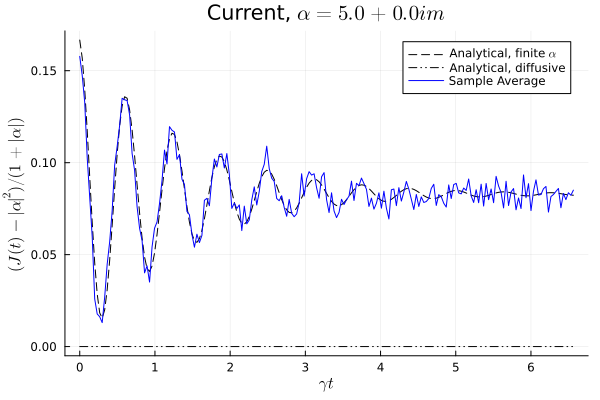

"/home/ste1nb0ck/Documents/Research/MonitoringMetrology/notebooks/JumpTimeSample/Analysis/CurrentPlots/current_5.0+i0.0.pdf"

In [19]:
p = plot(cfg["GAMMA"]*tlist[1:ntimes], (analyticalcurrent .-norm(cfield)^2)/(1.0+norm(cfield)), label="Analytical, finite "*L"\alpha",
    color="black", linestyle=:dash, title="Current, "*L"\alpha=%$(cfield)",
    xlabel = L"\gamma t", ylabel=L"(J(t) - |\alpha|^2)/(1+|\alpha|)")

plot!(cfg["GAMMA"]*tlist[1:ntimes], analyticalcurrent_diffusive, label="Analytical, diffusive",
    color="black", linestyle=:dashdotdot, 
    )

plot!(cfg["GAMMA"]*tlist[1:ntimes], (currentmean .- norm(cfield)^2)/(1.0+norm(cfield)) , color="blue", label="Sample Average")

display(p)
savefig("CurrentPlots/current_$(real(cfield))+i$(imag(cfield)).pdf")

In [20]:
# Obtain sample FT 
F_average = fftshift(fft(correlationfunction/(1+norm(cfield)^2)))
freqs = fftshift(fftfreq(ntimes, 1/dt));

# Analytical Autocorrelation
There's the following analytical expression for the autocorrelation:

$$ F(t, t+\tau) = \delta(\tau)K(t) + tr\{\mathcal{J}e^{\mathcal{L}\tau}\mathcal{J}\rho(t) \} - J(t)J(t+\tau)$$
where 
$$ 
    K(t) = \sum_k \nu_{k}^2 tr\{ L_k^\dagger L_k\rho(t)\}
$$
$$ 
    \mathcal{J}\rho = \sum_k \nu_{k}  L_k\rho L_k^\dagger
$$

Calculating the second term is the apparent problem, the strategy I have in mind is the following:

1. We know $\rho(t)$ from the means of the expectation values of the Pauli matrices
2. It's possible to calculate $\mathcal{J}\rho(t)$ from the above
3. The Bloch coordinates are extracted, and they are used as initial conditions in the differential equation
   to obtain the action of the Lindblad propagator
4. Repeat acting with $\mathcal{J}$

For $\tau<0$ the expression is

$$ F(t, t+\tau) = \delta(\tau)K(t) + tr\{\mathcal{J}e^{\mathcal{L}\tau}\mathcal{J}\rho(t-\tau) \} - J(t)J(t+\tau)$$


In [21]:
shifted_tlist = tlist .- tlist[t];

In [22]:
function analytical_autocorrelation_aux1(r_t, tau)
    2*(J_vectorization*exp(tau*liouvillian_vectorization)*J_vectorization*r_t)[1]
end
function analytical_autocorrelation_aux1_diffusive(r_t, tau)
    2*(H_vectorization*exp(tau*liouvillian_vectorization)*H_vectorization*r_t)[1]
end

analytical_autocorrelation_aux1_diffusive (generic function with 1 method)

In [23]:
r_t = 0.5*[1.0, x[t], y[t], z[t]]
analytical_autocorrelation = Vector{Float64}(undef, ntimes)
analytical_autocorrelation_diffusive = Vector{Float64}(undef, ntimes)
for k in 1:t-1
    analytical_autocorrelation[k] = analytical_autocorrelation_aux1(0.5*[1.0, x[k], y[k], z[k]], tlist[t]-tlist[k])
    analytical_autocorrelation_diffusive[k] = analytical_autocorrelation_aux1_diffusive(0.5*[1.0, x[k], y[k], z[k]], tlist[t]-tlist[k])
end 

for k in t:ntimes
    analytical_autocorrelation[k] = analytical_autocorrelation_aux1(0.5*[1.0, x[t], y[t], z[t]], tlist[k]-tlist[t])
    analytical_autocorrelation_diffusive[k] = analytical_autocorrelation_aux1_diffusive(0.5*[1.0, x[t], y[t], z[t]], tlist[k]-tlist[t])
end 
analytical_autocorrelation .-= analyticalcurrent[t] .* analyticalcurrent[:]
analytical_autocorrelation_diffusive .-= analyticalcurrent_diffusive[t] .* analyticalcurrent_diffusive[:]
# add the delta 
analytical_autocorrelation[t] += 2*(J_vectorization*r_t)[1]/dt
analytical_autocorrelation_diffusive[t] += 1/dt

#analytical_autocorrelation ./= 1 + norm(cfield)^2;


31.162985043038063

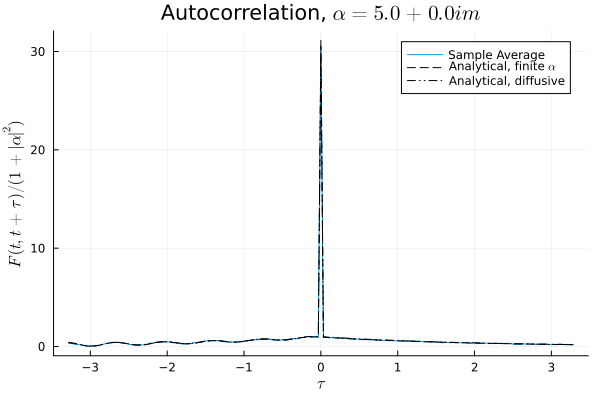

"/home/ste1nb0ck/Documents/Research/MonitoringMetrology/notebooks/JumpTimeSample/Analysis/AutocorrelationPlots/autocorrelation_5.0+i0.0.pdf"

In [24]:
p = plot(shifted_tlist[1:ntimes], correlationfunction[1:ntimes]/(1+norm(cfield)^2), 
    label="Sample Average", xlabel=L"\tau",ylabel=L"F(t, t+\tau)/(1+|\alpha|^2)", title="Autocorrelation, "*L"\alpha=%$(cfield)"
    )
plot!(shifted_tlist[1:ntimes], analytical_autocorrelation[1:ntimes]/(1+norm(cfield)^2),
    label="Analytical, finite "*L"\alpha", color="black", linestyle=:dash)
plot!(shifted_tlist[1:ntimes], analytical_autocorrelation_diffusive[1:ntimes], label="Analytical, diffusive",
    color="black", linestyle=:dashdotdot)
display(p)
savefig("AutocorrelationPlots/autocorrelation_$(real(cfield))+i$(imag(cfield)).pdf")

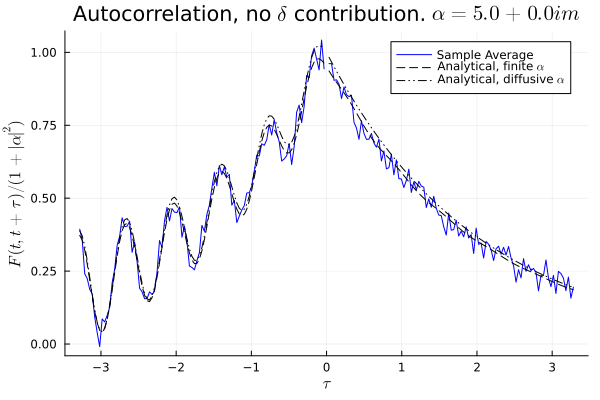

"/home/ste1nb0ck/Documents/Research/MonitoringMetrology/notebooks/JumpTimeSample/Analysis/AutocorrelationPlots/autocorrelation_nodelta_5.0+i0.0.pdf"

In [25]:
p = plot(shifted_tlist[1:t-1], (correlationfunction[1:t-1])/(1+norm(cfield)^2), 
    label="Sample Average", xlabel=L"\tau",ylabel=L"F(t, t+\tau)/(1+|\alpha|^2)", 
    title="Autocorrelation, no "*L"\delta"*" contribution. "*L"\alpha=%$(cfield)", color="blue")

plot!(shifted_tlist[t+1:ntimes], correlationfunction[t+1:ntimes]/(1+norm(cfield)^2), 
     label=false, color="blue")

plot!(shifted_tlist[t+1:ntimes], analytical_autocorrelation[t+1:ntimes]/(1+norm(cfield)^2), label="Analytical, finite "*L"\alpha", linestyle=:dash, color="black" )
plot!(shifted_tlist[1:t-1], analytical_autocorrelation[1:t-1]/(1+norm(cfield)^2), label=false, linestyle=:dash, color="black" )

plot!(shifted_tlist[t+1:ntimes], analytical_autocorrelation_diffusive[t+1:ntimes], label="Analytical, diffusive "*L"\alpha",
    linestyle=:dashdotdot, color="black" )
plot!(shifted_tlist[1:t-1], analytical_autocorrelation_diffusive[1:t-1], label=false,
    linestyle=:dashdotdot, color="black" )

display(p)
savefig("AutocorrelationPlots/autocorrelation_nodelta_$(real(cfield))+i$(imag(cfield)).pdf")


In [26]:
# Now go with the FTs
F_analytical = fftshift(fft(analytical_autocorrelation/(1+norm(cfield)^2)));
F_analytical_diffusive = fftshift(fft(analytical_autocorrelation_diffusive));

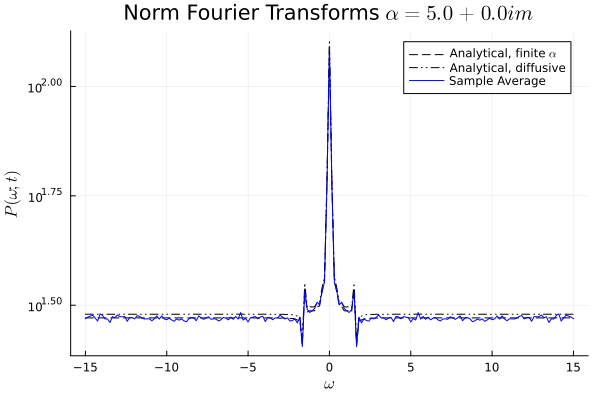

"/home/ste1nb0ck/Documents/Research/MonitoringMetrology/notebooks/JumpTimeSample/Analysis/AutocorrelationPlots/autocorrelation_ft_5.0+i0.0.pdf"

In [27]:
p = plot(freqs, abs.(F_analytical), label="Analytical, finite "*L"\alpha", color="black", linestyle=:dash, yscale=:log10)
plot!(freqs, abs.(F_analytical_diffusive), label="Analytical, diffusive", color="black", linestyle=:dashdotdot)
plot!(freqs, abs.(F_average), label="Sample Average ",
    color="blue", title="Norm Fourier Transforms "*L"\alpha=%$(cfield)", xlabel=L"\omega", ylabel=L"P(\omega; t)")
display(p)
savefig("AutocorrelationPlots/autocorrelation_ft_$(real(cfield))+i$(imag(cfield)).pdf")